In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point
from pyproj import Transformer

import contextily as ctx
from shapely import wkt
import pyproj
from shapely.geometry import Polygon

In [16]:
file_path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/Water Quality Portal/2023 - Getoetste data 2021-2022/Individueel_A.xlsx"
df = pd.read_excel(file_path)

In [8]:
selected_columns = [
    "Stofnaam_bollen",
    "filter",
    "numericvalue_aangepast",
    "begindatum",
    "xcoordinate",
    "ycoordinate"
]
df_selected = df[selected_columns].copy()

df_selected["begindatum"] = pd.to_datetime(df_selected["begindatum"], errors='coerce')


In [11]:
rd_to_wgs84 = pyproj.Transformer.from_crs("EPSG:28992", "EPSG:4326", always_xy=True)

df_selected["lon"], df_selected["lat"] = zip(*df_selected.apply(
    lambda row: rd_to_wgs84.transform(row["xcoordinate"], row["ycoordinate"]), axis=1
))

df_selected["geometry"] = df_selected.apply(
    lambda row: f"POINT ({row['lon']:.9f} {row['lat']:.9f})", axis=1
)

In [12]:
df_selected.head()

,Stofnaam_bollen,filter,numericvalue_aangepast,begindatum,xcoordinate,ycoordinate,lon,lat,geometry
0,Geleidendheid,1,850.91,1970-01-01 00:00:00.000044517,209632,610762,6.210081,53.480228,POINT (6.210081402 53.480227974)
1,Niet gedefinieërd,1,8.09,1970-01-01 00:00:00.000044517,209632,610762,6.210081,53.480228,POINT (6.210081402 53.480227974)
2,Niet gedefinieërd,1,20.30,1970-01-01 00:00:00.000044517,209632,610762,6.210081,53.480228,POINT (6.210081402 53.480227974)
3,Niet gedefinieërd,1,5.00,1970-01-01 00:00:00.000044517,209632,610762,6.210081,53.480228,POINT (6.210081402 53.480227974)
4,Aluminium (Al),1,10.00,1970-01-01 00:00:00.000044517,209632,610762,6.210081,53.480228,POINT (6.210081402 53.480227974)


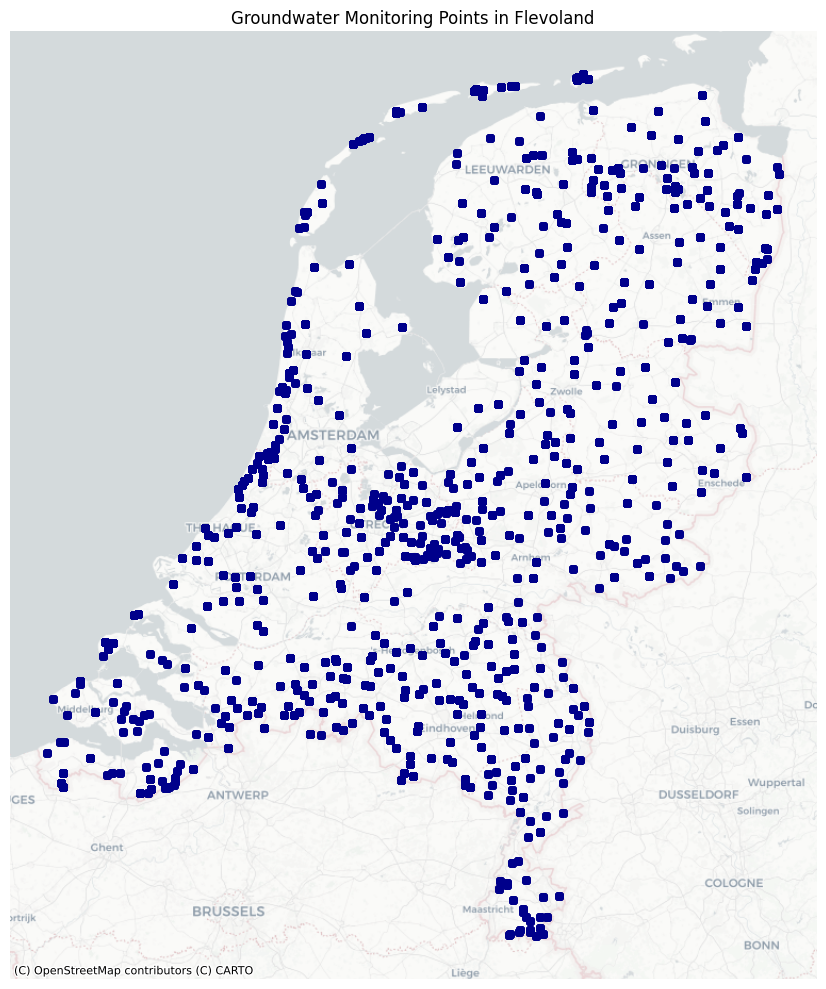

In [22]:
# If the geometry column is already shapely Points, we skip parsing
if not isinstance(df_selected["geometry"].iloc[0], str):
    gdf = gpd.GeoDataFrame(df_selected, geometry="geometry", crs="EPSG:4326")
else:
    from shapely import wkt
    df_selected["geometry"] = df_selected["geometry"].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df_selected, geometry="geometry", crs="EPSG:4326")

gdf_web = gdf.to_crs(epsg=3857)   #convert to Web Mercator for plotting

ax = gdf_web.plot(figsize=(10, 10), color="darkblue", alpha=0.6, markersize=30)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.title("Groundwater Monitoring Points in Flevoland")
plt.tight_layout()
plt.show()

In [23]:
# limit AOI to Flevolant (coordinates taken from Wiki)
flevoland_bbox = Polygon([
    (5.105, 52.236),
    (6.033, 52.236),
    (6.033, 52.863),
    (5.105, 52.863),
    (5.105, 52.236)
])

In [24]:
gdf = gpd.GeoDataFrame(df_selected, geometry="geometry", crs="EPSG:4326")

gdf_flevoland_bbox = gdf[gdf.within(flevoland_bbox)]

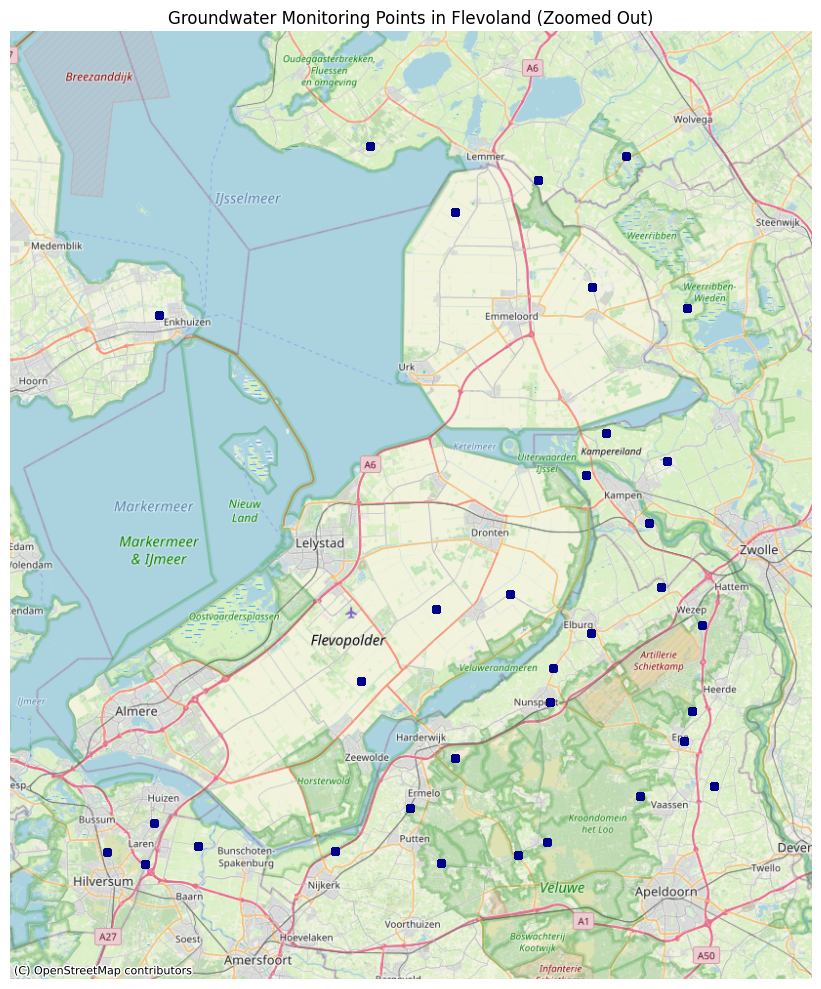

In [28]:
ax = gdf_flevoland_bbox.to_crs(epsg=3857).plot(
    figsize=(10, 10), color="darkblue", alpha=0.6, markersize=30
)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

x_buffer = (xlim[1] - xlim[0]) * 0.1
y_buffer = (ylim[1] - ylim[0]) * 0.1

ax.set_xlim(xlim[0] - x_buffer, xlim[1] + x_buffer)
ax.set_ylim(ylim[0] - y_buffer, ylim[1] + y_buffer)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()
plt.title("Groundwater Monitoring Points in Flevoland (Zoomed Out)")
plt.tight_layout()
plt.show()

Checking number of Nitrate data points in different provinces (without missing values + after 2000)

1: Filter for rows from the year 2000 or later

2: Filter for Filter values of 1 or 2

3: Filter out rows with missing Nitrate values

In [38]:
path = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/well_chem_data/flevoland_well_combined.csv"

df = pd.read_csv(path)

df['Date'] = pd.to_datetime(df['Date'], utc=True, errors='coerce')

# filter for dates in 2000 or later
df_after_2000 = df[df['Date'].dt.year >= 2000]

len(df_after_2000)

939

In [34]:
# 2000 or later
df_before_2000 = df[df['Date'].dt.year <= 2000]

len(df_before_2000)

1847

In [35]:
#rows where the "Filter" column has value 1 or 2
df_filtered_filter = df_after_2000[df_after_2000["Filter"].isin([1, 2])]

len(df_filtered_filter)

677

In [36]:
# remove rows with missing 'nitraat' values
df_final = df_filtered_filter[df_filtered_filter["Nitrate"].notna()]

len(df_final)

573

In [40]:

path_utrecht = "/Users/Administrator/Documents/University/Year 3/2b/Thesis/Bachelor-Thesis/data/raw/well_chem_data/utrecht_well_combined.csv"

df_utrecht = pd.read_csv(path_utrecht)

df_utrecht['Date'] = pd.to_datetime(df_utrecht['Date'], utc=True, errors='coerce')

df_utrecht_after_2000 = df_utrecht[df_utrecht['Date'].dt.year >= 2000]

df_utrecht_filtered = df_utrecht_after_2000[df_utrecht_after_2000['Filter'].isin([1, 2])]

df_utrecht_final = df_utrecht_filtered[df_utrecht_filtered["Nitrate"].notna()]

len(df_utrecht_final)

779